In [1]:
import os
import math
import numpy as np
from ctypes import CDLL, POINTER, c_double, c_float, c_bool, c_int16, c_int32
from scipy.io import wavfile
from IPython.display import display, Audio
from matplotlib import pyplot
from librosa.util import frame as create_windows
from librosa import note_to_hz
from scipy.signal import resample

In [2]:
current_dir = os.path.dirname(os.path.realpath(os.path.abspath('')))

In [3]:
shared_file = os.path.normpath(
    current_dir + 
    '/reaper/build/libreaper_c_api.dylib'
)
reaper = CDLL(shared_file)

reaper.init.argtypes = [
    c_float,
    c_bool,
    c_bool,
]
reaper.process.argtypes = [
    POINTER(c_int16),
    c_int32,
]
reaper.get_output_error.restype = c_bool
reaper.get_output_length.restype = c_int32
reaper.get_output.argtypes = [
    POINTER(c_float),
    POINTER(c_float),
]

In [4]:
audio_path = os.path.normpath(current_dir + '/audio/humming_short.wav')
sample_rate, audio = wavfile.read(audio_path)
display(Audio(data=audio, rate=sample_rate))

In [5]:
do_highpass = True
do_hilbert = True
reaper.init(
    sample_rate,
    do_highpass,
    do_hilbert,
)

1772257040

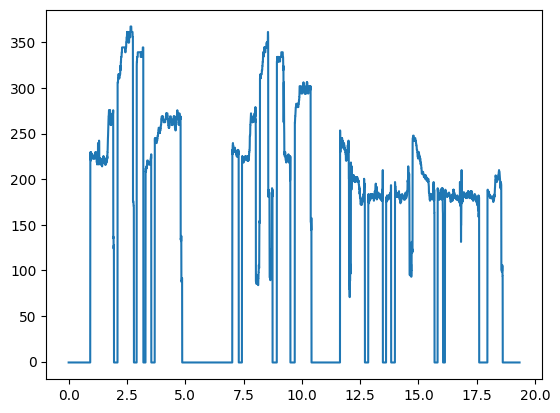

In [6]:
def reaper_process(audio):
    reaper.process(
        (c_int16 * len(audio))(*audio),
        len(audio),
    )
    if reaper.get_output_error():
        print('Error occurred.')
    output_length = reaper.get_output_length()
    output_times = (c_float * output_length)()
    output_freqs = (c_float * output_length)()
    reaper.get_output(output_times, output_freqs)
    output_times = np.frombuffer(output_times, c_float)
    output_freqs = np.frombuffer(output_freqs, c_float)
    return output_times, output_freqs
    
output_times, output_freqs = reaper_process(audio)
pyplot.plot(output_times, output_freqs)
pyplot.show()

In [7]:
shared_file = os.path.normpath(
    current_dir + 
    '/smb_pitch_shifter/build/libsmb_api.dylib'
)
smb = CDLL(shared_file)

smb.init.argtypes = [
    c_int32, 
    c_int32
]
smb.process_window.argtypes = [
    POINTER(c_int16),
    c_double
]

In [8]:
window_length = 4096
hop_length = window_length // 2
windows = create_windows(x=audio, frame_length=window_length, hop_length=hop_length, axis=0) * np.hanning(window_length)

In [9]:
# Cmaj scale
scale = list(map(note_to_hz, [
    'A1', 'B1', 
    'C2', 'D2', 'E2', 'F2', 'G2', 'A2', 'B2',
    'C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3',
    'C4', 'D4', 'E4', 'F4', 'G4'
]))

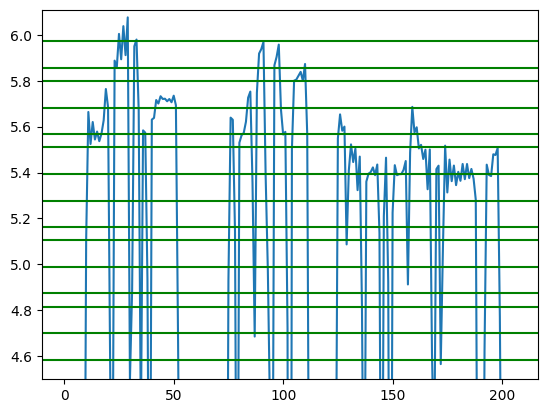

In [10]:
resampled_freqs = resample(output_freqs, num=len(windows))
pyplot.plot(np.log(resampled_freqs - resampled_freqs.min() + 1))
for hz in scale:
    pyplot.axhline(np.log(hz), c='green')
ax = pyplot.gca()
ax.set_ylim([np.log(90), np.log(450)])
pyplot.show()

In [11]:
shift_multipliers = []
for freq in resampled_freqs:
    if freq < 50:
        shift_multipliers.append(1)
        continue
        
    closest_note_freq = 0
    closest_distance = 999999999
    for note_freq in scale:
        distance = abs(np.log(note_freq) - np.log(freq))
        if distance < closest_distance:
            closest_distance = distance
            closest_note_freq = note_freq
    
    shift_multipliers.append(closest_note_freq / freq)

In [12]:
smb.init(window_length, sample_rate)
new_windows = []
for i in range(len(windows)):
    window = windows[i].astype(np.int16).tolist()
    new_window = (c_int16 * len(window))(*window)
    shift_multiplier = shift_multipliers[i]
    smb.process_window(
        new_window,
        shift_multiplier
    )
    new_windows.append(new_window)

In [13]:
shifted_audio = np.zeros((len(windows) + 1) * hop_length).astype(np.int16)
for i in range(len(windows)):
    window = new_windows[i]
    for j in range(len(window)):
        index = i * hop_length + j
        shifted_audio[index] += window[j]

In [ ]:
shifted_times, shifted_freqs = reaper_process(shifted_audio)

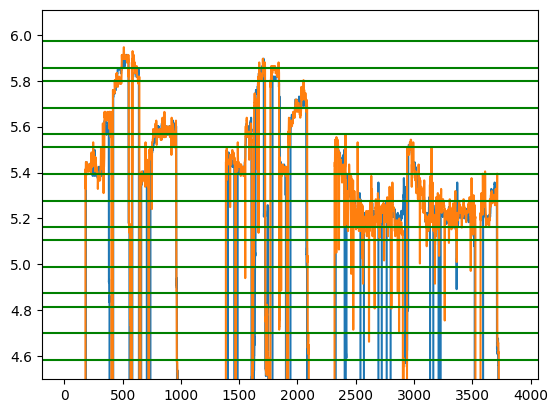

In [18]:
pyplot.plot(np.log(output_freqs - output_freqs.min() + 1))
pyplot.plot(np.log(shifted_freqs - shifted_freqs.min() + 1))
for hz in scale:
    pyplot.axhline(np.log(hz), c='green')
ax = pyplot.gca()
ax.set_ylim([np.log(90), np.log(450)])
pyplot.show()

In [15]:
display(Audio(data=shifted_audio, rate=sample_rate))